# IPBME6UE INF_BA_VZ: Exercise #1- Segmentation

## Spring 2024

## Scripnic Dinu

In [1]:
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import os
import skimage

from pathlib import Path

%matplotlib inline

# The Data

The data consist of sets of DICOM images that hold completely anonymized chest CT scans (see section “Reading in the Data”). DICOM (Digital Imaging and Communications in Medicine) is a standardized format for transmitting medical image data. Each DICOM file is composed of two parts: the image data as well as a header giving you a lot of metadata about the patient and specifics about the imaging parameters (e.g. space between slices).

You can choose any of the patients in the dataset to prototype your code, but you are expected to generalize your algorithm to work for at least ten different patients to show robustness. The more you do, the more you’ll prove your algorithm.

First, let's make sure you can read in the data.

In the cell below, replace the `scans_path` string variable with the (relative or absolute) path to the place where you put the data. Particularly, look for the folder that contains scans. Each scan is in its own folder and has a name, e.g. 0d7a1bc2-352b-41f3-882c-1c8ad9f89847. `scans_path` should be the folder that contains these oddly named folders. Once you do this, you can run the cell below to look at all the metadata associated with that slice.

In [2]:
# Each chest CT scan is a folder with a name like R_num that within contains many .dcm files with their slice number as a name. 

local_path = Path.cwd()
scans_path = "LungCT-Diagnostic Pre-Surgery Contrast Enhanced" 
full_path = local_path / scans_path
list_of_scans = os.listdir(scans_path)

# for figuring out the controls lets experiment with slice 42 of scan 2
scan_num = 2
scan_path = os.path.join(scans_path, list_of_scans[scan_num])
list_of_slices = os.listdir(scan_path)
slice_num = 42
slice_path = os.path.join(scan_path, list_of_slices[slice_num])

# read in the full path to the file as ds
ds=dicom.read_file(slice_path) # you may have to use pydicom instead of dicom 

## That's a lot of metadata, right? Don't be scared. Next, let's actually look at the slice.

We can see that there are many data fields in a DICOM file. There's a lot of patient information stored in a DICOM - name, birthdate, and so on. For obvious privacy reasons, this data has been completely anonymized. 

Run the following cell to view the image associated with this person.

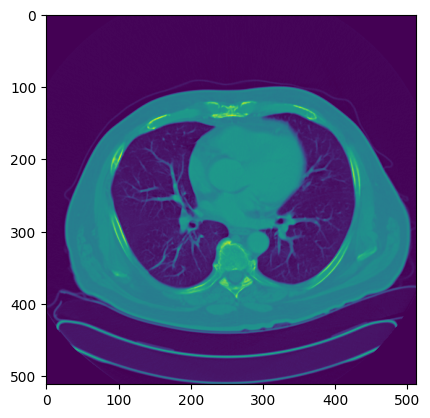

<class 'numpy.ndarray'> 406.76830673217773 uint16


In [3]:
rawimg= ds.pixel_array
plt.imshow(rawimg, cmap='viridis')
plt.show()
print(type(rawimg), np.mean(ds.pixel_array), rawimg.dtype)

We're all set. On to the problem set!

# Introduction

Segmentation is the process of dividing a given image into sections. This can be binary segmentation (if you wanted to separate the image into foreground and background) or a multilabel segmentation if you wanted to label many different parts of an image (see figures below for examples of each). Segmentation is an extremely interesting problem in image analysis, and it has yet to be solved perfectly. From an algorithmic point of view, we can approach the problem using tools such as graph cuts, watershed, flood fill / region growing, statistical set separation, etc... From a machine learning point of view, we can think of the problem as a pixel classification problem that can be solved with some supervised learning algorithm (assuming we had some ground truth training data) or an unsupervised learning algorithm (such as k-means clustering).

<img src = "figures/segmentation0.jpg" >

(a) Binary Segmentation - A binary segmentation of some grains of rice. We can use segmentation to create a binary mask that allows us to separate the rice (foreground) from the darker background. 

<img src = "figures/segmentation1.jpg" >

(b) Multilabel Segmentation - A multilabel segmentation of a coronal section from a magnetic resonance image of the brain. We can see that different colors represent different sections of the brain. For example, the white matter on the left side of the brain is labeled with a different color than the white matter on the right side of the brain. 

A lot of radiological image analysis begins with segmentation. For example, to quantitatively describe a lung nodule, you may want to collect data on its edge sharpness, its total volume, and/or the mean intensity of voxels in the nodule. However, to do this, we have to first be able to segment the nodule and cleanly define its boundaries. This can get extremely hairy. For example, in the chest, it might be hard to teach a program to segment a nodule in the lung from a seed voxel. It's important to make sure the nodule segmentation doesn’t bleed into the pericardium, as the voxel intensities for a nodule and the fleshy bits in the pericardium are very similar. We can try and restrict this through lung field segmentation (basically, we want to go through our chest CT scans and segment out the lungs) and thus define a region of interest, but this gets increasingly difficult as more and more problems pop up.

This assignment will help you understand many core concepts taught in the lectures and hopefully
integrate the lectures into a medically relevant application. The goals of this project include:

a. Understanding medical image data format - specifically, DICOM.

b. Understanding thresholding techniques - specifically, Otsu’s Threshold.

c. Understanding morphological image analysis techniques, and expanding this understanding into 3D.

d. Understanding image convolution and expanding it into efficient 3D.

e. Understanding visualization in 3D.

f. Embracing creativity and exploring image analysis.

These can seem daunting tasks for a first timer, but we promise the final results will be amazingly cool! Stick with us, and as always, don't hesitate to ask for help.

**The main goal of this assignment is to segment out the lungs, and only the lungs, from these CT slices, and then create a 3D rendering of the lungs to give yourself some way to qualitatively assess how good your segmentation is. Basically, given a chest CT series, you will be creating something like this:**

<img src = "figures/lung_field_segmentation.png" >

# Step 1: (5 points)

Some important DICOM fields like $RescaleIntercept$ and $RescaleSlope$ determine how the image pixel values should be interpreted. These metadata are critical for quantitative imaging methods like CT. The default raw pixel values are arbitrary units returned from the actual machine used and may differ based on the scanner manufacturer. We’d like to convert these raw values to Hounsfield units, which you learned about in lecture, in order to have some standardization among all of our CT scans. The conversion formula is:

$$ \textrm{Hounsfield Units} = RescaleSlope \times \textrm{Raw Image} + RescaleIntercept $$

<img src="figures/houndsfield.png">

### Deliverable: 

* Read in the raw data for a CT slice, and convert its pixel values into Hounsfield units. 
* Compute and print the max, min, mean, and standard deviation of both images (raw data and Hounsfield units) 
* Compare them.

In [4]:
slice_path = os.path.join(scans_path, 'R_075', 'ffae5146-34cf-4ee1-b159-e992193348e3.dcm')

ds = dicom.read_file(slice_path)
raw_image = ds.pixel_array
raw_image_stats = np.max(raw_image), np.min(raw_image), np.mean(raw_image), np.std(raw_image)

intercept = ds.RescaleIntercept
slope = ds.RescaleSlope
hu_image = raw_image * slope + intercept
hu_image_stats = np.max(hu_image), np.min(hu_image), np.mean(hu_image), np.std(hu_image)
print(f'Hounsfield Unit = {slope} * raw + {intercept}')
print(f'Raw Image Stats: max: {raw_image_stats[0]}, min: {raw_image_stats[1]}, mean: {raw_image_stats[2]}, std: {raw_image_stats[3]}')
print(f'HU Image Stats: max: {hu_image_stats[0]}, min: {hu_image_stats[1]}, mean: {hu_image_stats[2]}, std: {hu_image_stats[3]}')


Hounsfield Unit = 1 * raw + -1024
Raw Image Stats: max: 2351, min: 0, mean: 452.81705474853516, std: 487.9139318717175
HU Image Stats: max: 1327.0, min: -1024.0, mean: -571.1829452514648, std: 487.9139318717175


# Output comparison
> Row Image Stats: max: 2351, min: 0, mean: 452.81705474853516, std: 487.9139318717175
<br>
> HU Image Stats: max: 1327.0, min: -1024.0, mean: -571.1829452514648, std: 487.9139318717175

## Comparison
* While the standard deviation is the same, the mean, max, and min are different. This is expected, as the Hounsfield units are a linear transformation of the raw image.
* The pixel value range also differs, HU has a range from -1024 to 1327, while the raw image has a range from 0 to 2351. 

## HU image comments
* The big standard deviation is suggesting a wide variation of materials, from air to bone.
* The minimum of 1024 means that the image also has air in it, which is expected in a chest CT.


# Step 2: (25 points)

As you may have noticed, we live in a 3D world. The next main part of your problem will be to go from all the individual slices of the CT scan (each one stored as a .dcm file) into a 3D volume. Basically, you’ll need to figure out some way to order these slices in the right order. Read in a few of the DICOM images from your patient, and try using different DICOM fields as a sorting key. You may find one of them works well in sorting the slices in the correct order. Try looking up what that field means in the DICOM standard. *Hint: you may want to initialize a blank 3D matrix called `volCT` or something.*

Here is the pseudocode for one way (you are free to do your own) of creating this volume and filling it:

<img src = "figures/pseudocode.png"> 

Visualize the NumPy volume you create from the stacks. Feel free to do this within Python with something like matplotlib.

### Deliverable: 

Make the 3D volume and display 25 of the slices in correct order for us, like this:

<img src = "figures/lung_order.png"> 

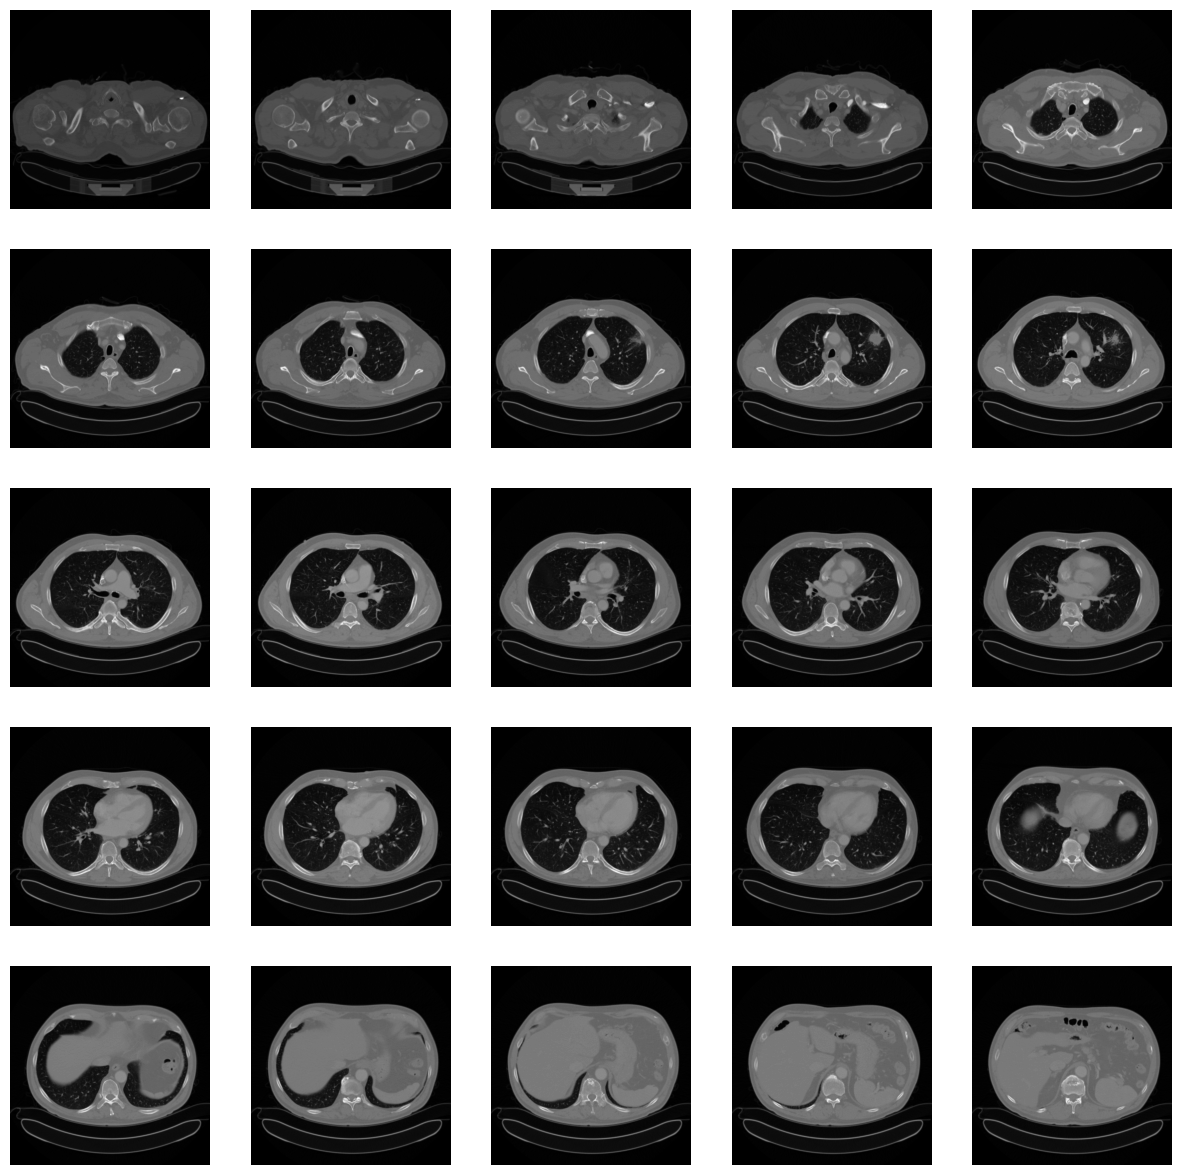

In [5]:
ds.pixel_array.shape # (512, 512)
slices_path = os.path.join(scans_path, 'R_075')
list_of_slices = os.listdir(slices_path)
volCt = np.zeros([512, 512, len(list_of_slices)])
list_of_slices = [dicom.dcmread(os.path.join(slices_path, file)) for file in list_of_slices]
list_of_slices = sorted(list_of_slices, key=lambda x: int(x.InstanceNumber)) # also SliceLocation, but i didnt check if it was the same
for i, slice in enumerate(list_of_slices):
    volCt[:,:,i] = slice.pixel_array

fig, ax = plt.subplots(5,5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(volCt[:,:,(i*5+j)*4], cmap='gist_gray')
        ax[i,j].axis('off')
plt.rcParams['figure.figsize'] = (30, 18)
plt.show()

# Step 3 (5 points)
### Deliverable: 

What is the default numerical type used to store raw image data in DICOM files? Answer in the cell below.

In the coding cell below that one, convert all the voxels in your volume to a **float32** type number between 0.0 and 1.0; output the min, max, and dtype (datatype) of the voxels in your volume before and after you convert.

In [6]:
# The default numerical type used to store raw image data in DICOM files is `int16`.

print(f'Voxel shape: {volCt.shape}, min: {np.min(volCt)}, max: {np.max(volCt)}, dtype: {volCt.dtype}')

# Brute force approach
newVolCt = np.zeros([512, 512, len(list_of_slices)], dtype=np.float32)
max_input = np.max(volCt)
for i in range(volCt.shape[-1]):
    slice = volCt[:,:,i]
    slice = (slice / max_input).clip(0, 1)
    slice = np.array(slice, dtype=np.float32)
    newVolCt[:,:,i] = slice

# smarter way, i guess
newVolCt1 = skimage.exposure.rescale_intensity(volCt, out_range=(0, 1)).astype(np.float32) # this gives the same result as the above for loop
print((newVolCt == newVolCt1).all()) # here is the proof
print(f'Voxel shape: {newVolCt1.shape}, min: {np.min(newVolCt1)}, max: {np.max(newVolCt1)}, dtype: {newVolCt1.dtype}')

Voxel shape: (512, 512, 112), min: 0.0, max: 4095.0, dtype: float64
True
Voxel shape: (512, 512, 112), min: 0.0, max: 1.0, dtype: float32


# Step 4 (10 points)

Now that we have our 3D matrix of lung CT data, we can try to segment out our lung. We know from lecture that the pixel values of CT scans are given in Hounsfield units, where lower Hounsfield units correspond to low density materials (like air) that are not highly attenuative for X-rays and higher Hounsfield units correspond to highly attenuative materials, like bone.

<img src = "figures/histWithThresh.png"> 

That red line separating the two groups of pixels is the [Otsu's threshold](https://en.wikipedia.org/wiki/Otsu%27s_method). We can find a nice separating value of our two modes with [this Otsu’s method](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html).

### Deliverable:

A histogram of the Hounsfield units from a typical CT scan will be significantly [bimodal](https://en.wikipedia.org/wiki/Multimodal_distribution)! Why?

**Answer:** YOUR ANSWER TO STEP 4 PART 1 HERE

Next, find the Otsu's threshold in your volume of pixels and plot the histogram of of your pixels with this line like the example figure. You will find these links ([1](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html), [2](https://matplotlib.org/stable/gallery/axes_grid1/scatter_hist_locatable_axes.html), and [3](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.axvline.html)) useful if you have not done this before.

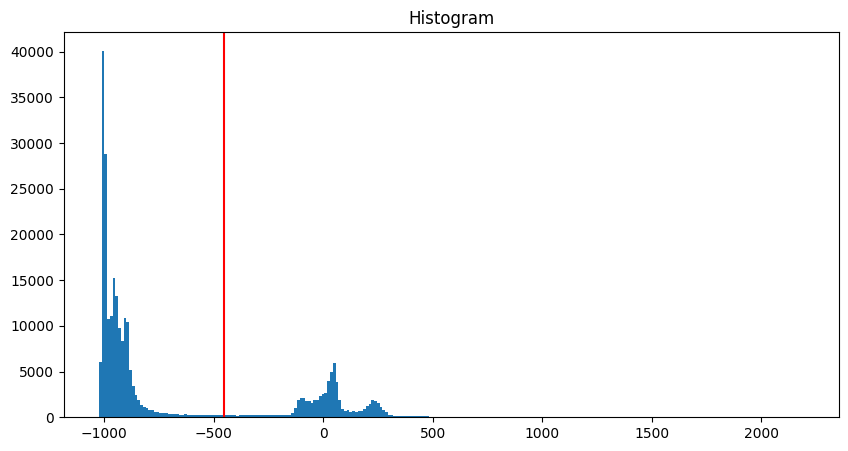

In [7]:
# It will be bimodal because we have 2 peaks in the histogram, on both sides of the histogram.
# It is bimodal because we have presence of air and dense structures in the image.

ds = dicom.read_file(full_path / 'R_006' / '4a1a0a37-600d-4cf3-aa35-212cc1899a33.dcm')
image = ds.pixel_array
image = image * ds.RescaleSlope + ds.RescaleIntercept
thresh = skimage.filters.threshold_otsu(image)

plt.figure(figsize=(10, 5))
plt.hist(image.ravel(), bins=256)
plt.title('Histogram')
plt.axvline(thresh, color='r')
plt.show()



# Step 5 (10 points)

We can now take a look at the performance of Otsu’s threshold. We want all the pixels less than Otsu’s threshold since the lung is in the darker (low Hounsfield units) part of the image.

<img src="figures/otsu.png">

Despite the crude binary cutoff, we can see that this is really close to what we want for a final result, albeit a little noise.

### Deliverable:

Display for us one slice of the CT scan showing a binary image after applying thresholding using Otsu's method.

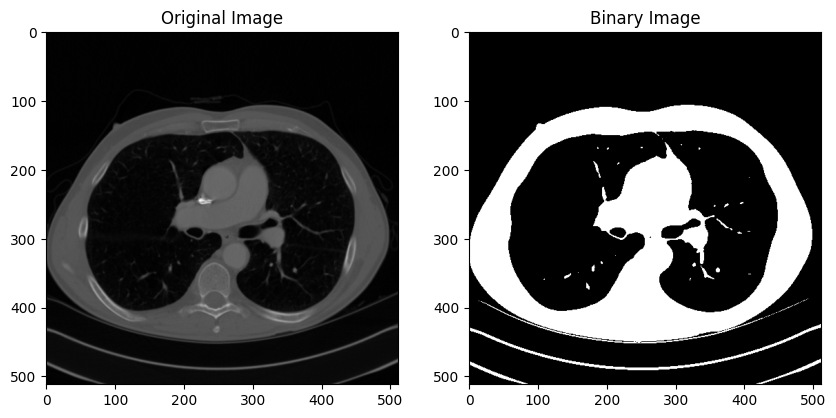

In [8]:
# i will do this agian here so each cell is independent
ds = dicom.read_file(full_path / 'R_006' / '4a1a0a37-600d-4cf3-aa35-212cc1899a33.dcm')
image = ds.pixel_array
image = image * ds.RescaleSlope + ds.RescaleIntercept
thresh = skimage.filters.threshold_otsu(image)
binary = image > thresh

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(binary, cmap='gray')
ax[1].set_title('Binary Image')
plt.show()


# Step 6 (30 points)

We can see our dark lungs surrounded by lighter-colored tissue, which is then again surrounded by the darkness of the 0-pixels. Our lung segmentation is thus, interestingly, completely separated from the segmentation of the outside air. These two sets of binary-connected components are completely unconnected. 

> Can you think of a simple way of differentiating between the dark lungs and the dark air outside the body?

Here's one way to do it - we assume that the outside air will always be touching the edge of the image and the lungs will not:

<img src="figures/pseudocode2.png">

However, the segmentation is still rough around the edges. There are a few pixels of noise around the main lung (components that weren’t touching the edges but still aren’t part of the lung). Luckily for us, these bits are relatively small in size. We can, therefore, quickly filter them out based on their volume. We want to choose connected components whose volume is larger than some threshold $V$. You can set $V$ arbitrarily (most noise will have pixel counts in the double digits or maybe low hundreds), as long as the lung volume should have a pixel count several orders of magnitude higher.
Here would be a possible pseudo-algorithm for this task:

<img src="figures/pseudocode3.png">

After this, we just want to smooth out the edges. The segmentation of our lung looks very ragged because it wasn’t able to pick out the lighter colored blood vessels in the lung. We can do this smoothing with a binary closing algorithm, provided by the `scikit-image` package (`skimage.morphology.binary_closing`). It works for both 2-dimensional and 3-dimensional binary matrices.

### Deliverable:

Implement the steps described here and display for us an ordered sample of the cuts from your boolean CT scan volume that has been smoothed, with only the pixels of the lung and trachea as 1/true, and everything else as 0/False,  like this:

<img src="figures/final.png">

In [9]:
def apply_otsu_threshold(image: np.array) -> np.array:
    trashhold = skimage.filters.threshold_otsu(image)
    binary = image < trashhold
    return binary


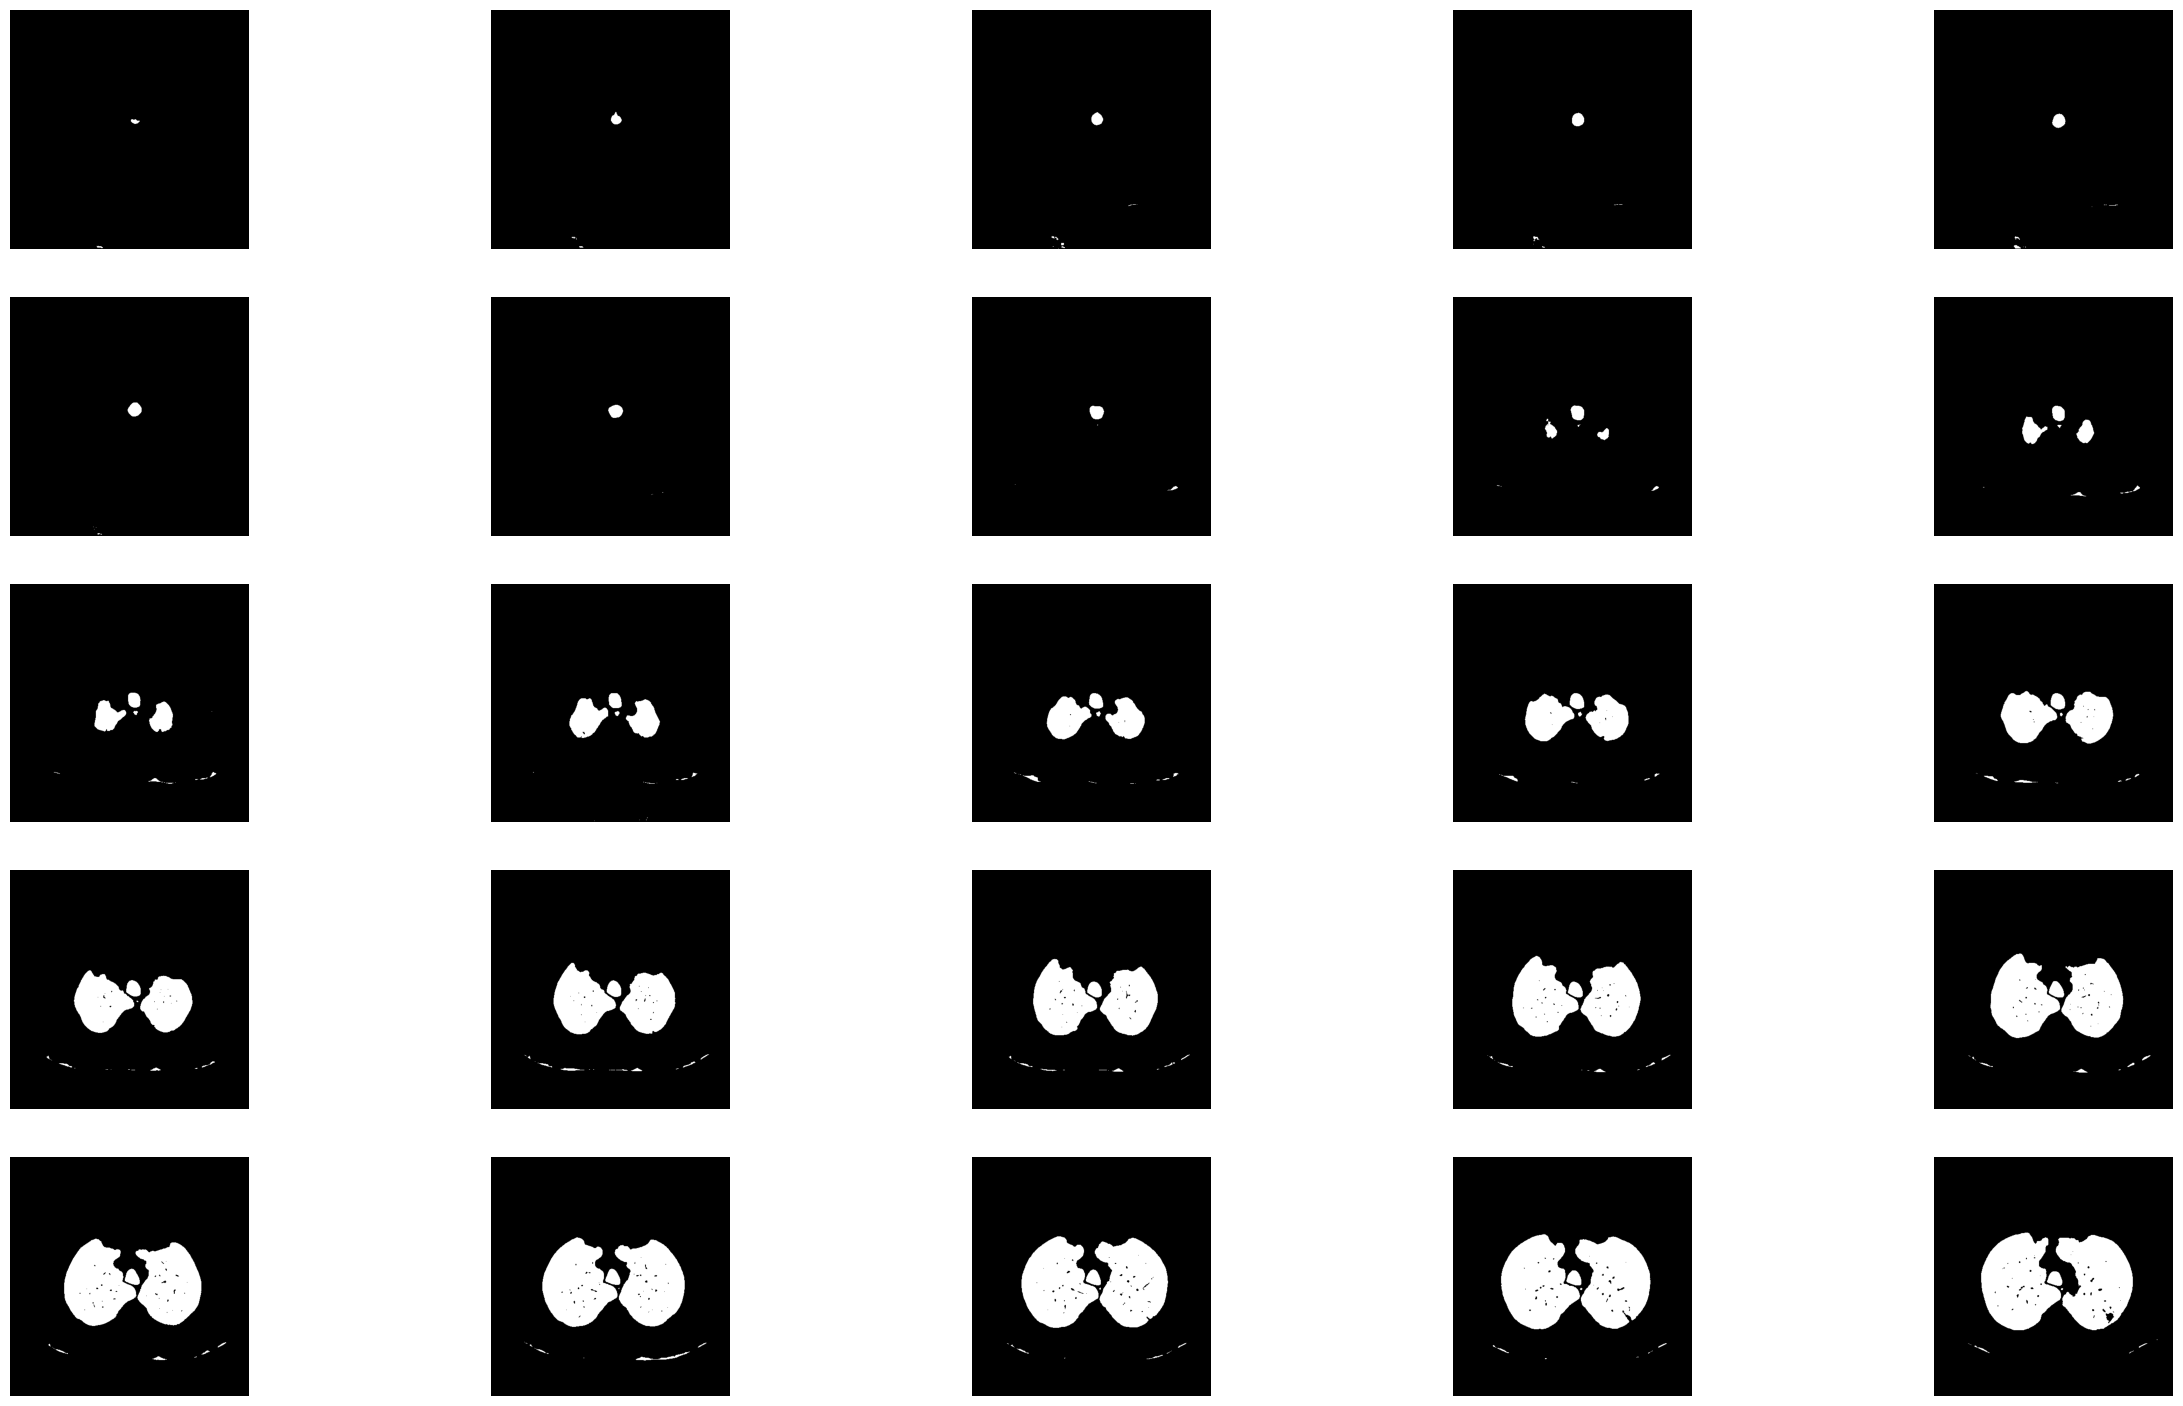

In [10]:
slices = [dicom.dcmread(full_path / 'R_020' / file) for file in os.listdir(full_path / 'R_020')]
slices = sorted(slices, key=lambda x: int(x.InstanceNumber))
volCt = np.zeros([512, 512, len(slices)], dtype=np.float32)
for i, slice in enumerate(slices):
    
    binary_mask = apply_otsu_threshold(slice.pixel_array)

    # its basically doing what is described in the pseudocode
    cleared = skimage.segmentation.clear_border(binary_mask)

    volCt[:,:,i] = cleared
    
fig, ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(volCt[:,:,i*5+j], cmap='gist_gray')
        ax[i,j].axis('off')
plt.rcParams['figure.figsize'] = (30, 18)
plt.show()


In [11]:
def filter_by_volume(image: np.array, volume:int) -> np.array:
    connected_components, component_count = skimage.measure.label(image, connectivity=1, return_num=True)
    for c in range(1, component_count + 1):  # Start from 1 as 0 is background
            # Check if the connected component is smaller than V
            if np.sum(connected_components == c) < volume:
                # Set all pixels of the connected component in smoothed_vol to 0
                image[connected_components == c] = 0
    return image


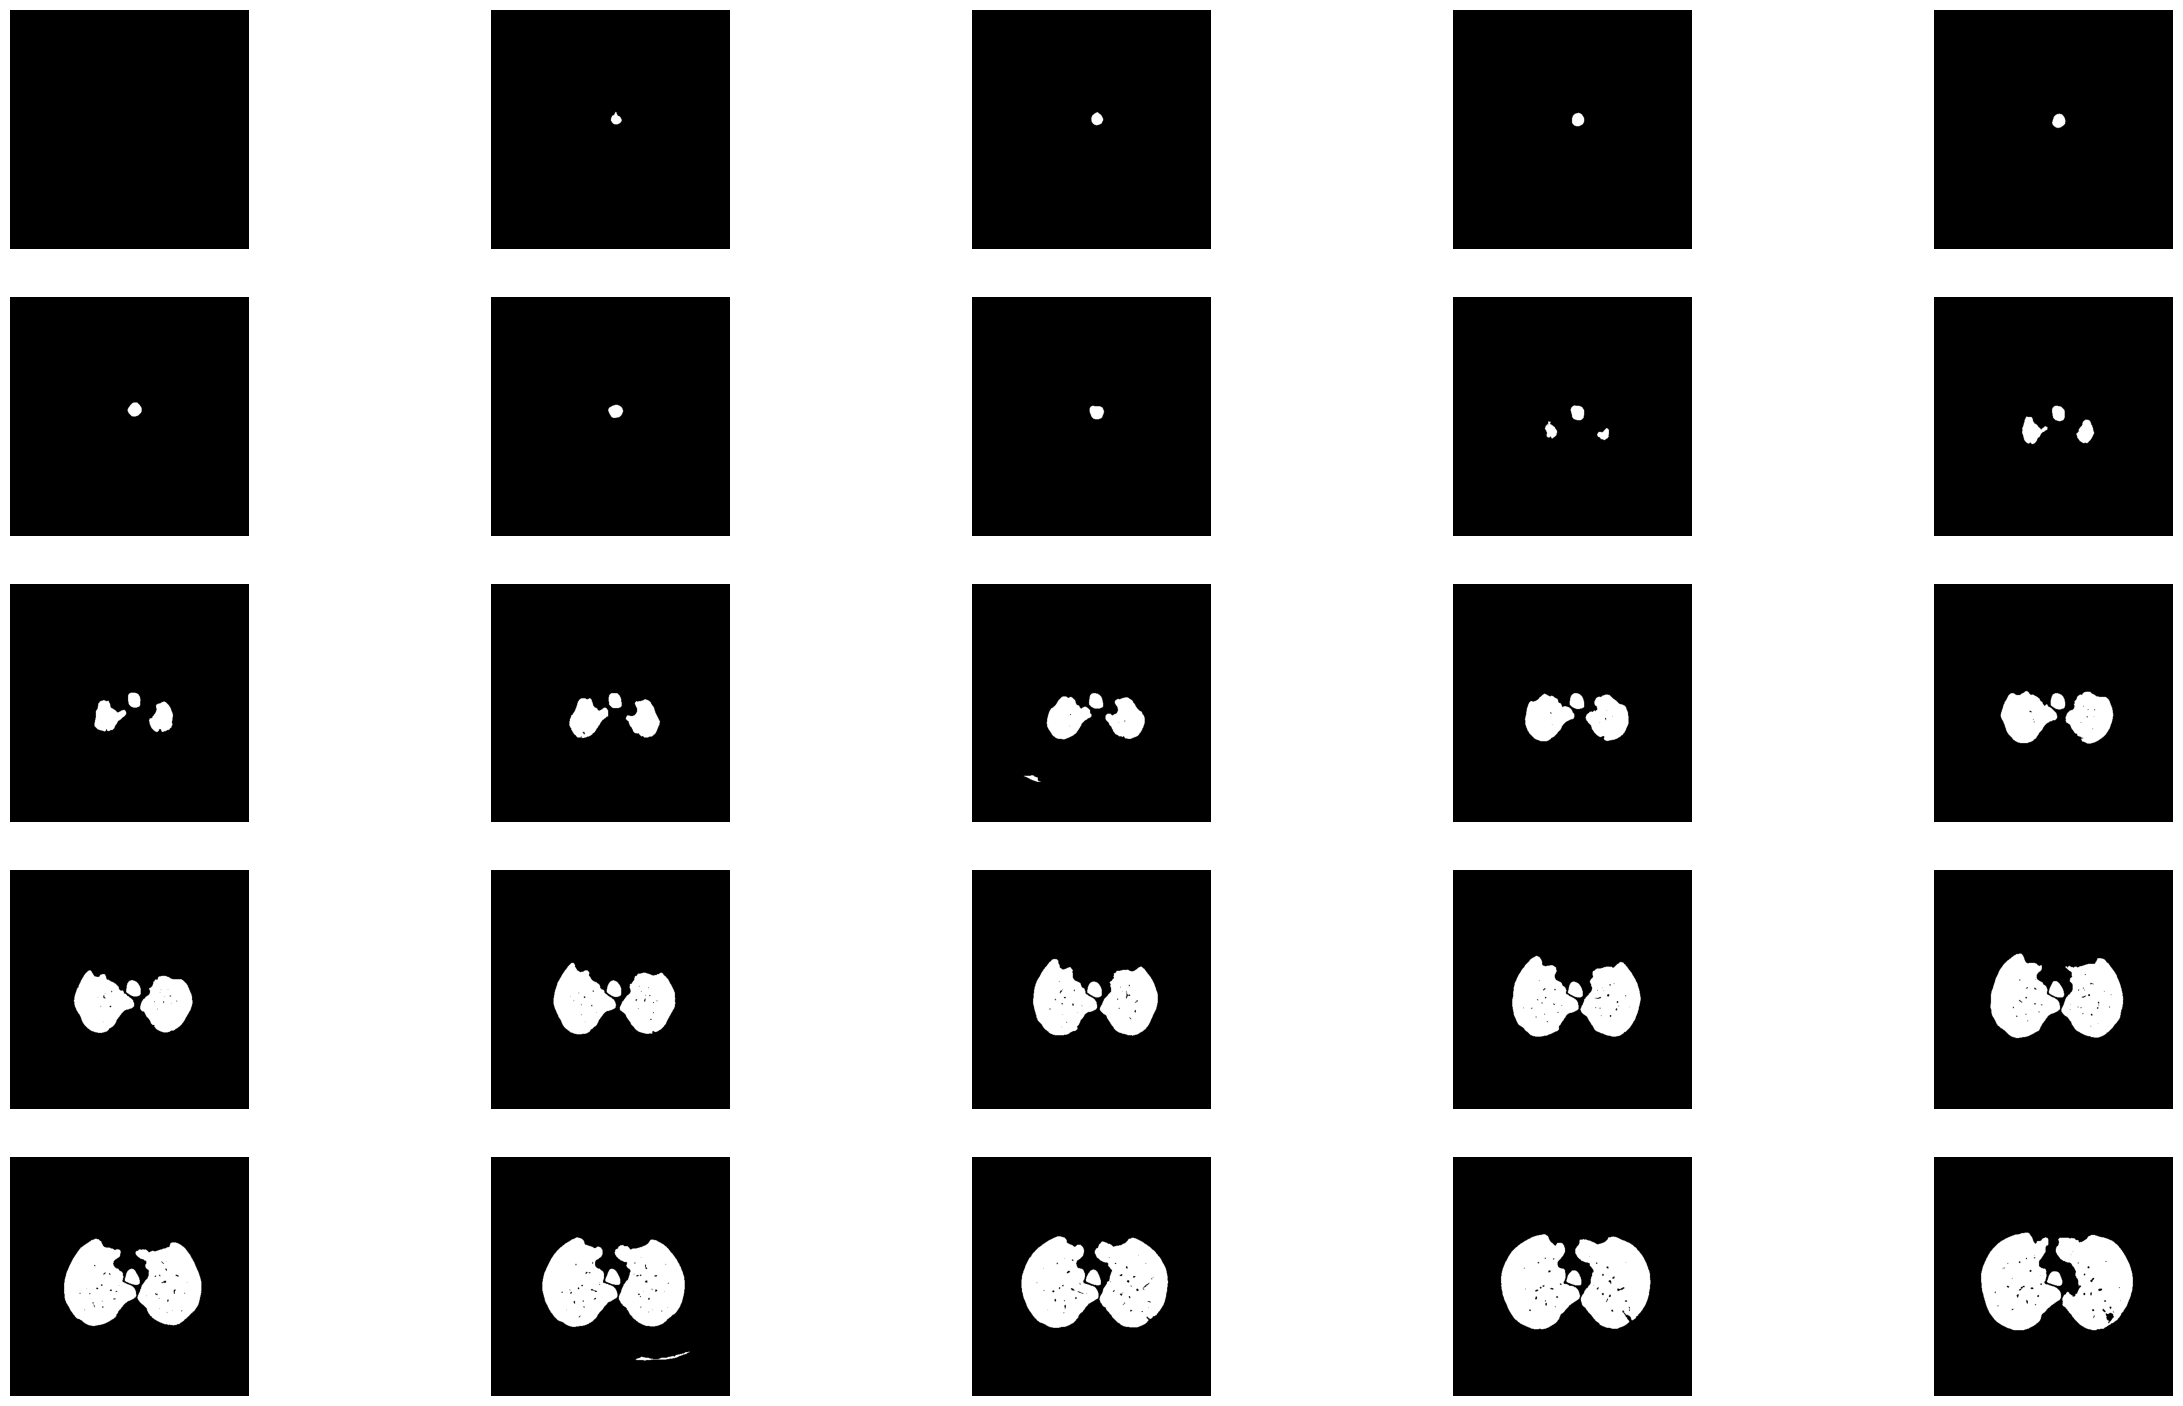

In [12]:
slices = [dicom.dcmread(full_path / 'R_020' / file) for file in os.listdir(full_path / 'R_020')]
slices = sorted(slices, key=lambda x: int(x.InstanceNumber))
original_slices = np.zeros([512, 512, len(slices)], dtype=np.float32)

for i, slice in enumerate(slices):
    
    binary_mask = apply_otsu_threshold(slice.pixel_array)

    cleared = skimage.segmentation.clear_border(binary_mask)

    filtered = filter_by_volume(cleared, 200)

    volCt[:,:,i] = cleared
    
fig, ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(volCt[:,:,i*5+j], cmap='gist_gray')
        ax[i,j].axis('off')
plt.rcParams['figure.figsize'] = (30, 18)
plt.show()


# Step 7 (5 points each, 15 points total)

Show that the segmentation works on 3 more scans.

## Deliverable:

Same as Step 6, but with different scans.

In [13]:
def segment_lungs(path_scans_folder:str) -> np.array:
    slices = [dicom.dcmread(os.path.join(path_scans_folder, file)) for file in os.listdir(path_scans_folder)]
    slices = sorted(slices, key=lambda x: int(x.InstanceNumber))
    volCt = np.zeros([512, 512, len(slices)])
    for i, slice in enumerate(slices):
        image = slice.pixel_array
        image = image * slice.RescaleSlope + slice.RescaleIntercept
        thresh = apply_otsu_threshold(image)
        cleared = skimage.segmentation.clear_border(thresh)
        filtered = filter_by_volume(cleared, 200)
        volCt[:,:,i] = filtered
    return volCt


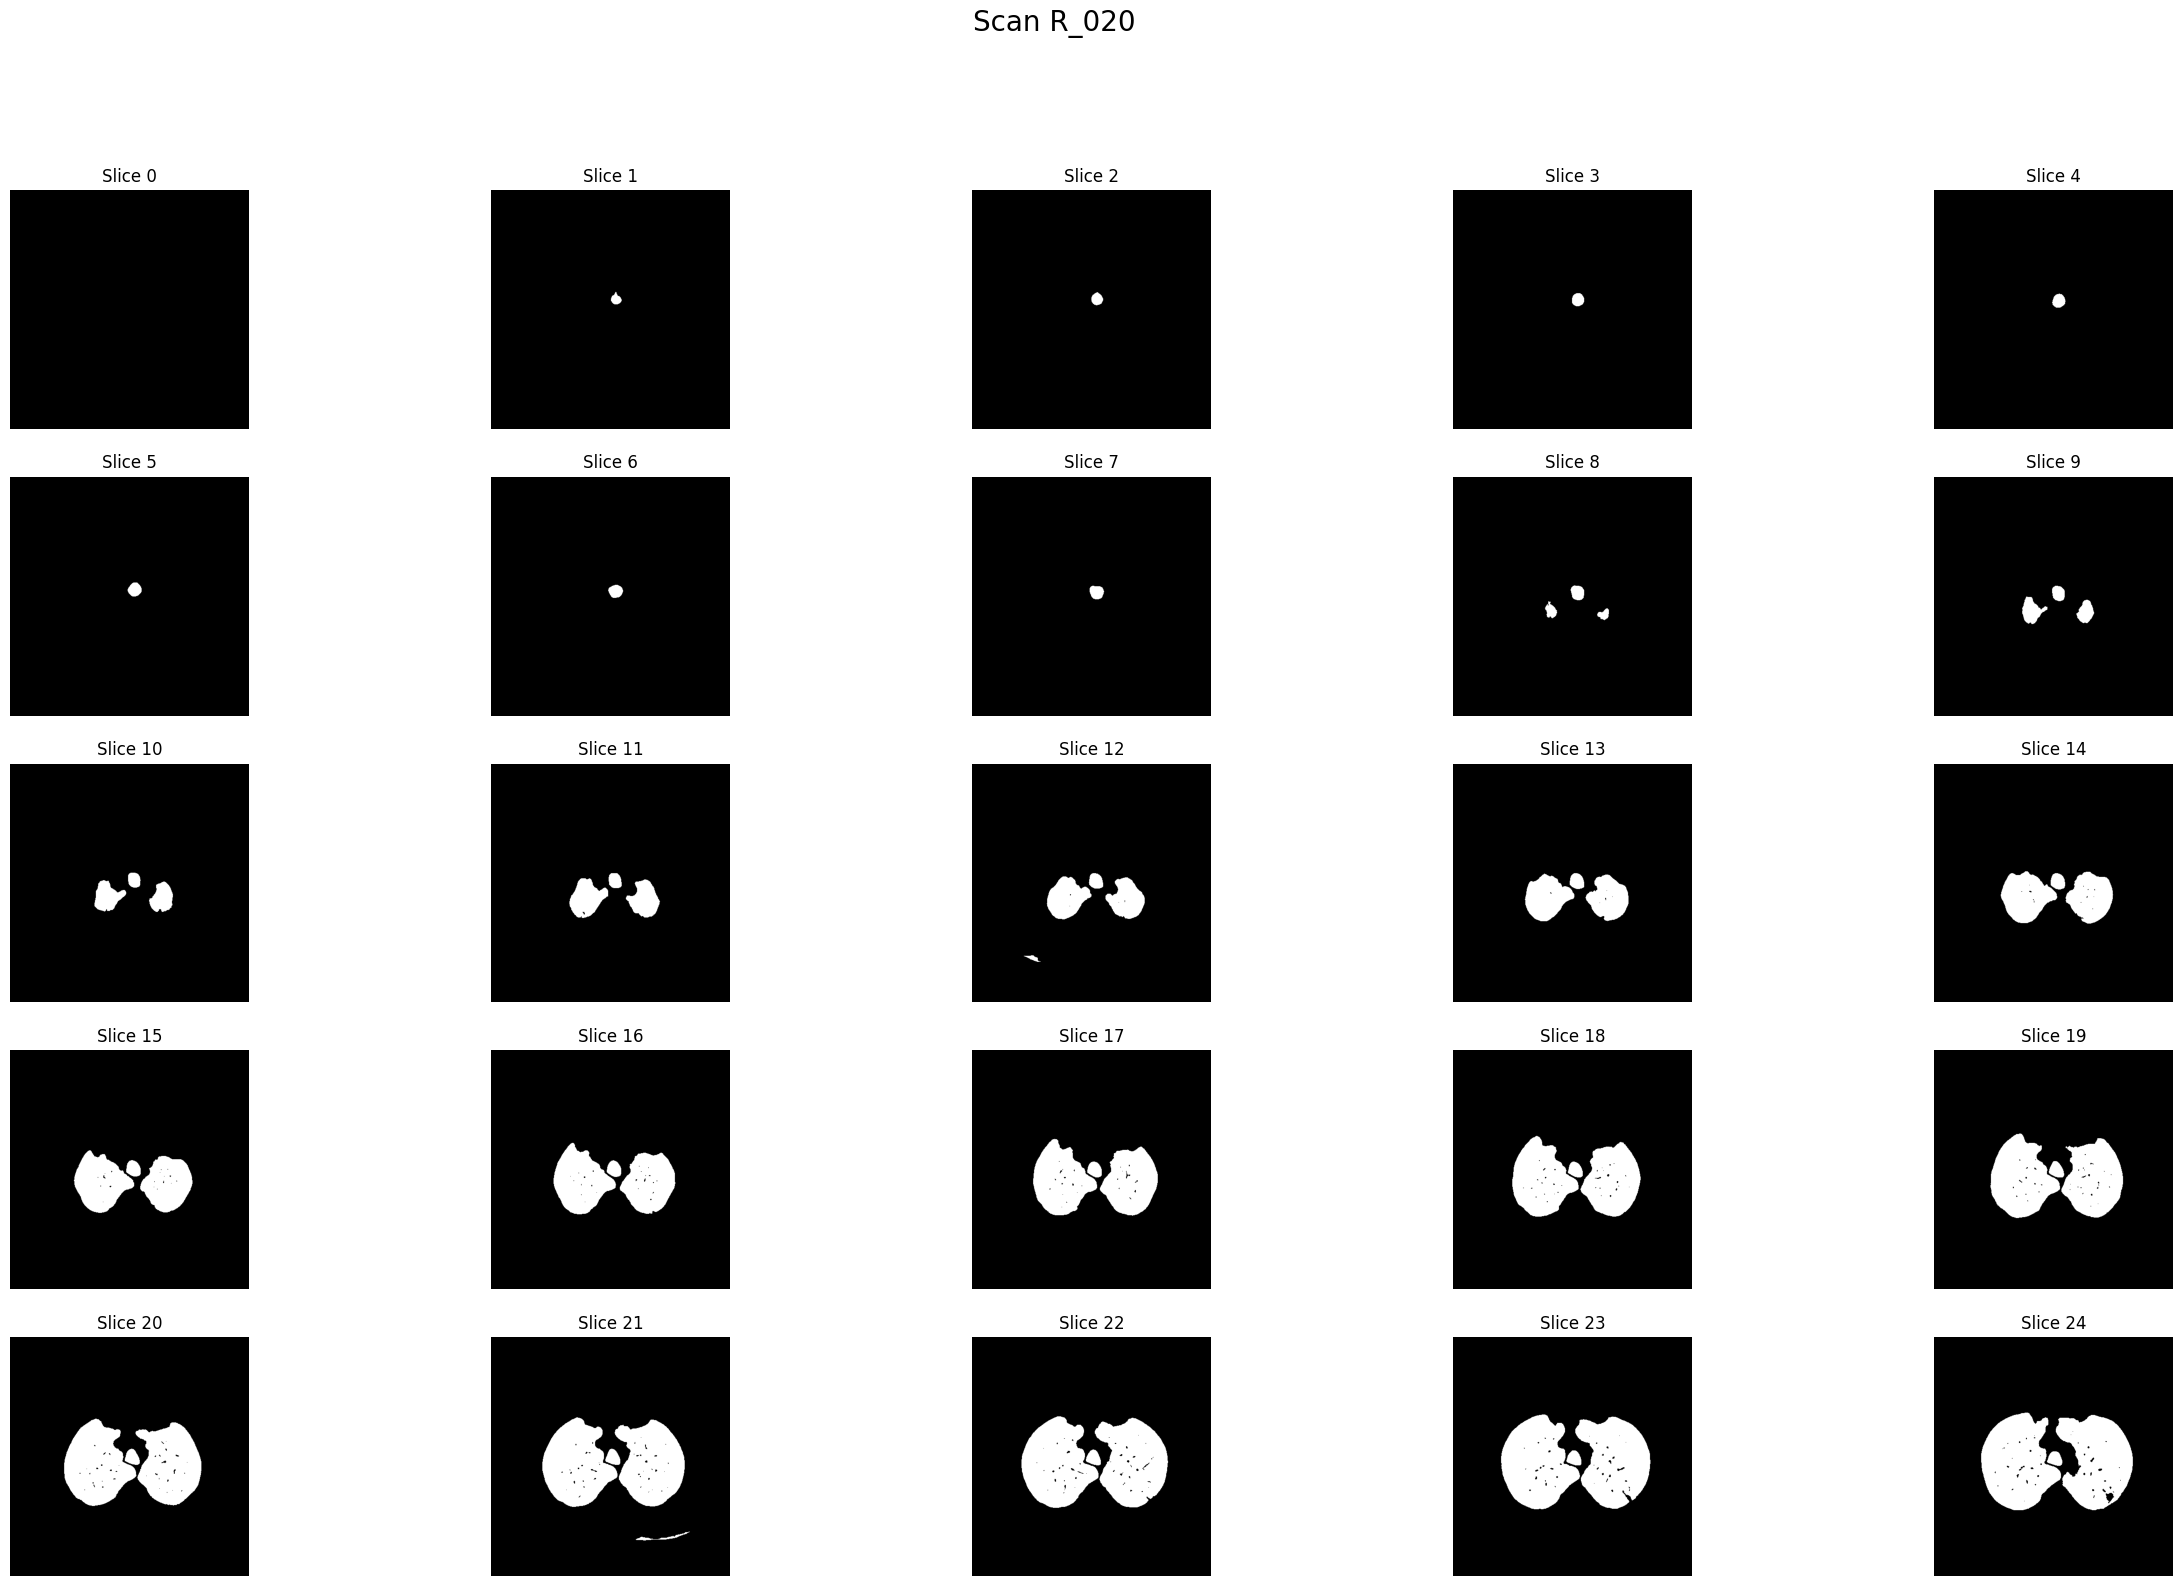

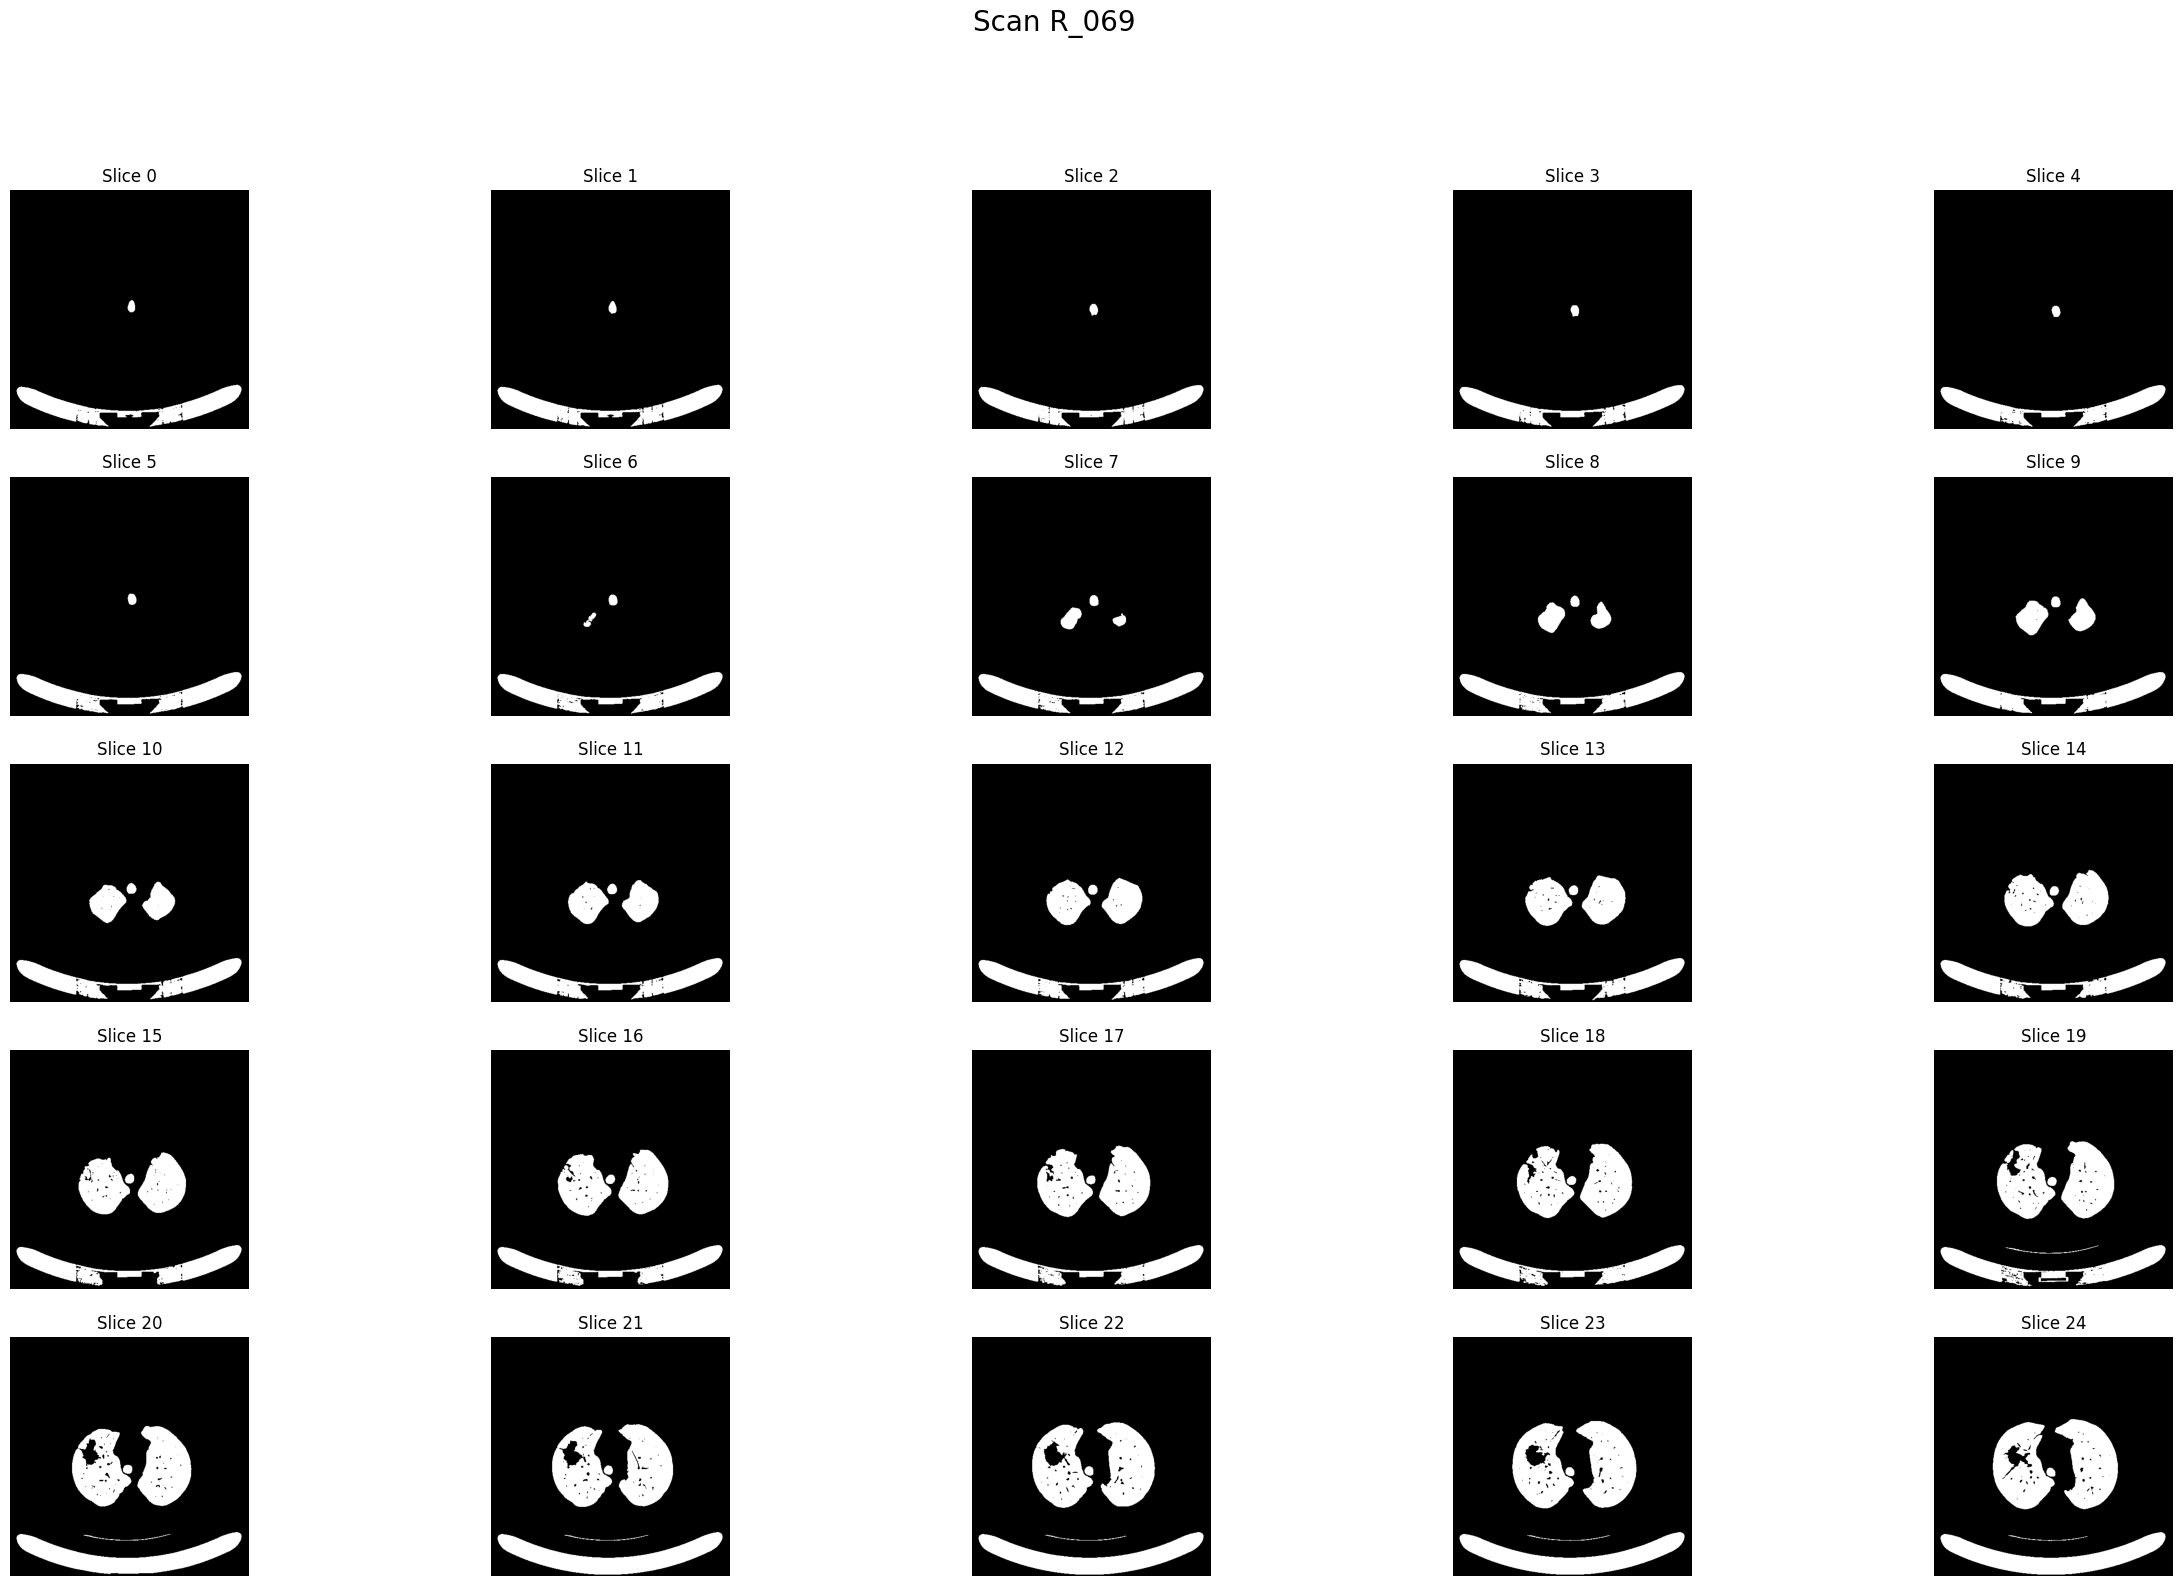

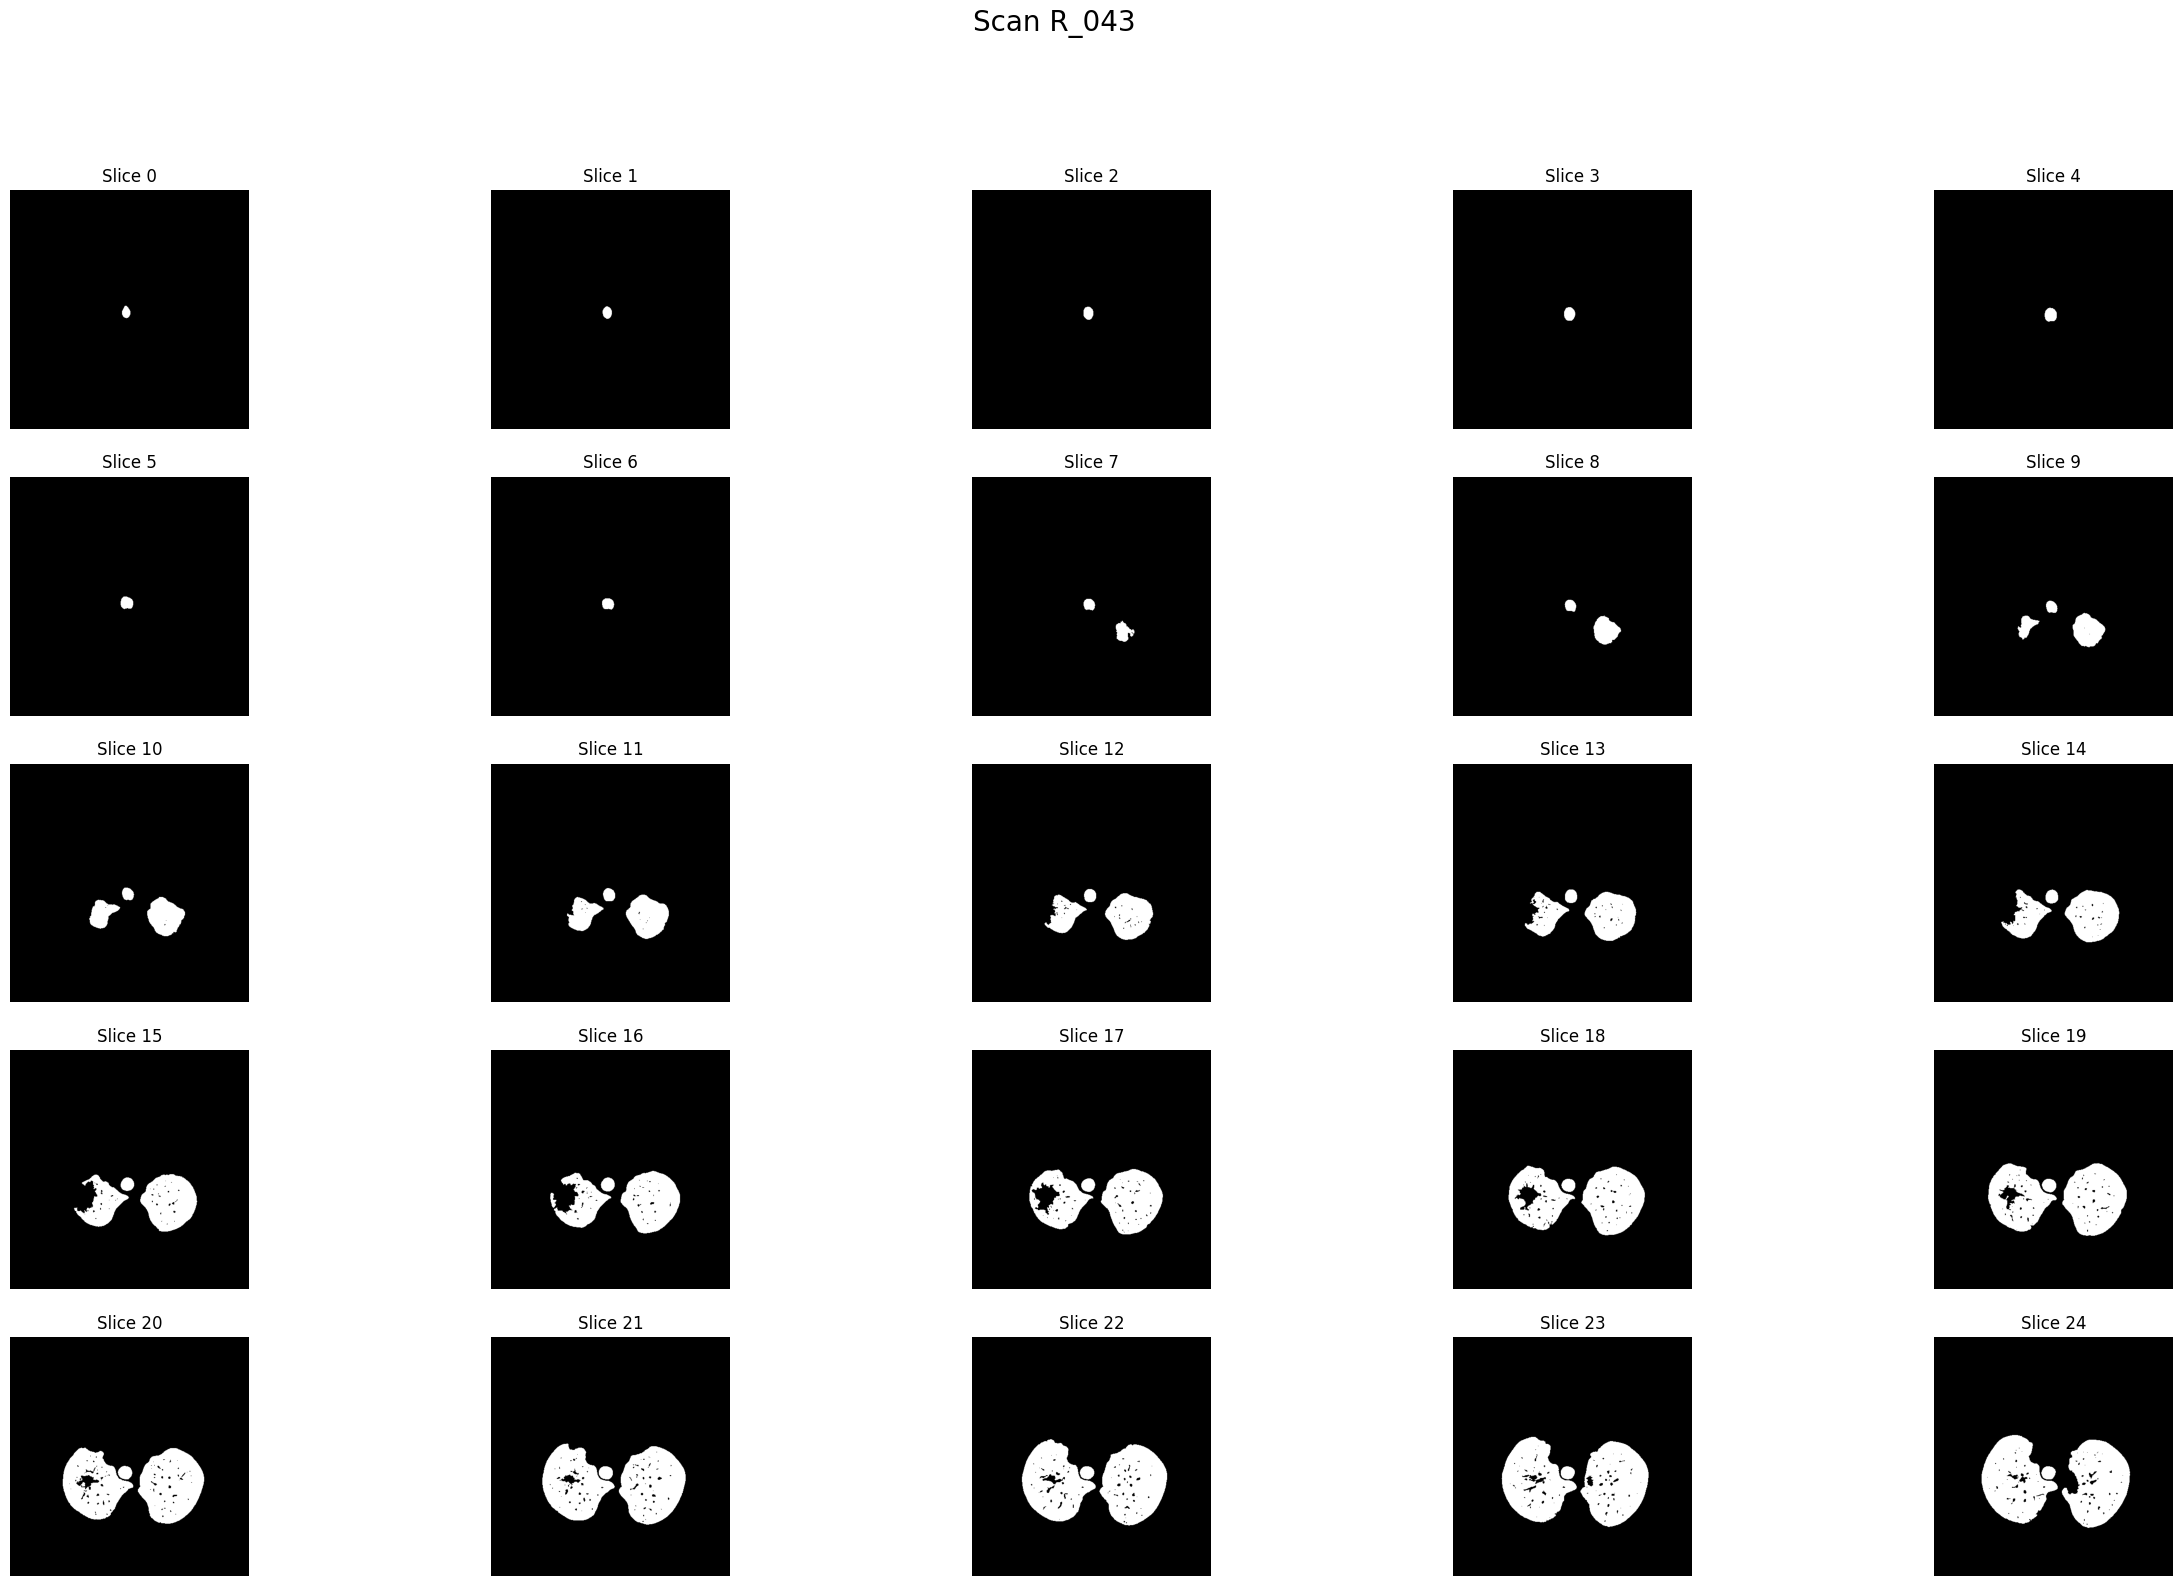

In [14]:
local_path = Path.cwd()
scans_path = "LungCT-Diagnostic Pre-Surgery Contrast Enhanced" 
full_path = local_path / scans_path
available_scans = os.listdir(full_path)
random_scans_3 = np.random.choice(available_scans, 3)
random_scans_3_path = [os.path.join(full_path, scan) for scan in random_scans_3]
segmented_lungs = [segment_lungs(path) for path in random_scans_3_path]
for i, scan in enumerate(segmented_lungs):
    fig, ax = plt.subplots(5,5)
    for j in range(5):
        for k in range(5):
            slice_num = j*5+k
            slice = scan[:,:,slice_num]
            ax[j,k].imshow(slice, cmap='gist_gray')
            ax[j,k].axis('off')
            ax[j,k].set_title(f'Slice {slice_num}')
    fig.suptitle(f'Scan {random_scans_3[i]}', fontsize=20)  # Adjust fontsize as needed
    plt.rcParams['figure.figsize'] = (30, 18)
    plt.show()

# Step 8 (Bonus 15 points, 5 points each)

If you’ve finished everything above, you’ve already done a full fledged segmentation. However, for an extra challenge, you can try your hand at:

1. Removing just the trachea so that your segmentation is just on the left and right lung without any of the trachea or bronchi. 

2. Separating out the two halves of the lung into left/right lungs.

3. There are a ton of python packages that help you visualize the lung as a whole. We highly recommend looking up some **marching cube algorithms**. You can also stay with [matplotlib and scikit-image](https://scikit-image.org/docs/stable/auto_examples/edges/plot_marching_cubes.html#sphx-glr-auto-examples-edges-plot-marching-cubes-py). Which should output a figure like this:

<img src="figures/lungs_3d_output.png">

Another, easier, way to go would probably be using something like Fiji. Simply [download Fiji](https://imagej.net/Fiji/Downloads) (available for Windows, Mac, and Linux). You can save all your 3D segmentation as binary image slices. Then, using Fiji, simply read in your image sequence (be sure to name your images some numeric count or something so that Fiji knows what order to read the images in). Then, go to `Plugins -> 3D Viewer`. This should give you a figure like what you see below:

<img src="figures/fiji.png">

Show us that this works on at least two scans.

In [25]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes

def plot_3d(image: np.array, title: str = ''):
    verts, faces, _, _ = marching_cubes(image, level=0.5)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')    

    mesh = Poly3DCollection(verts[faces], alpha=0.5)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, image.shape[0])
    ax.set_ylim(0, image.shape[1])
    ax.set_zlim(0, image.shape[2])
    fig.suptitle(title, fontsize=20)  # Adjust fontsize as needed
    plt.show()

for i, scan in enumerate(segmented_lungs):
    plot_3d(scan, title=f'Scan {random_scans_3[i]}')